In [929]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [930]:
df_selftext = pd.read_csv('../data/selftext.csv')
df_notext = pd.read_csv('../data/notext.csv')
df_posts = pd.read_csv('../data/notext.csv')

dflist = [df_selftext,df_notext,df_posts]

In [931]:
df_notext.shape

(9020, 13)

In [932]:
df_selftext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3695 entries, 0 to 3694
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subreddit      3695 non-null   object 
 1   selftext       3599 non-null   object 
 2   title          3689 non-null   object 
 3   upvote_ratio   3695 non-null   float64
 4   score          3695 non-null   int64  
 5   id             3695 non-null   object 
 6   author         3695 non-null   object 
 7   num_comments   3695 non-null   int64  
 8   created_utc    3695 non-null   object 
 9   retrieved_utc  3695 non-null   int64  
 10  updated_utc    3695 non-null   int64  
 11  post_date      3695 non-null   object 
 12  post_time      3695 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 375.4+ KB


# target

In [933]:
df_selftext.subreddit.value_counts()

bitcoin     2937
ethereum     758
Name: subreddit, dtype: int64

In [934]:
def targetize(df):
    df['subreddit'] = df.subreddit.apply(lambda x: 0 if x == 'bitcoin' else 1)
    return df

df_selftext,df_notext,df_posts = [targetize(i) for i in dflist]

In [935]:
df_selftext.shape

(3695, 13)

In [936]:
# a few nans from import blanks
df_selftext.isna().sum()

subreddit         0
selftext         96
title             6
upvote_ratio      0
score             0
id                0
author            0
num_comments      0
created_utc       0
retrieved_utc     0
updated_utc       0
post_date         0
post_time         0
dtype: int64

# Drop additional cols for now, would like to explore metadata (scoring, authorship, comment mapping is a bridge too far)

In [937]:
df_selftext['text'] = df_selftext['title'] +' ' + df_selftext['selftext']
df_notext['text'] = df_notext['title']

In [938]:
targetcols = ['subreddit', 'text']

In [939]:
for i in [df_selftext, df_notext]:
    i.drop(columns=[i for i in i.columns if i not in targetcols], inplace = True)

In [940]:
df_notext.head()

,subreddit,text
0,0,agree
1,0,snow fall and the matrix effects ascii art
2,0,bitcoin mining difficulty looks set to adjust ...
3,0,duck tales inflation lesson
4,0,tfym when you cashed out your ira and dumped i...


In [941]:
df_notext.isna().sum()

subreddit    0
text         1
dtype: int64

In [942]:
df_selftext.isna().sum()

subreddit      0
text         101
dtype: int64

In [943]:
for i in dflist:
    i.dropna(inplace = True)

# Eda, cleanup via tokenization / lemmatization

In [944]:
#https://stackoverflow.com/questions/61987040/how-to-lemmatise-a-dataframe-column-python
# https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

# could get very into lemmatization alone as all this is quite frustrating: https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word
# as an aside, spoke with patrick burns about the http://cltk.org/ project, as i  was scraping and parsing catullus manually until i found cltk via lemmatization.
# he specificically is working on this library for latin to tag part of speech with training to improve lemmatization https://github.com/diyclassics/la_dep_cltk_sm

tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [945]:
print(df_notext.subreddit.value_counts(normalize = True))
df_selftext.subreddit.value_counts(normalize = True)

0    0.780353
1    0.219647
Name: subreddit, dtype: float64


0    0.791875
1    0.208125
Name: subreddit, dtype: float64

In [946]:
def lemmatize_func(text):
        return ' '.join([lemmatizer.lemmatize(i) for i in tokenizer.tokenize(text)])

df_notext['text'] = df_notext.text.apply(lemmatize_func)
df_selftext['text'] = df_selftext.text.apply(lemmatize_func)


In [947]:
df_selftext.subreddit.value_counts()

0    2846
1     748
Name: subreddit, dtype: int64

# merge title / text

In [948]:
def split_df_to_target(df):
    btc = df[df['subreddit'] == 1]
    eth = df[df['subreddit'] == 0]
    
    btc.reset_index
    eth.reset_index
    
    return btc, eth

In [949]:
btc_notext, eth_notext = split_df_to_target(df_notext)
btc_selftext, eth_selftext = split_df_to_target(df_selftext)

# EDA

In [994]:
# adding stop words
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik wa ha amp text would get llet like nt know one use think http'.split())

# ngrams

In [995]:
def ngram_maker(df, transformer, stop_words, count, ngram_start, n_gram_stop):
    
    #df is df, transformer is what you'd call your transformer, the rest is the rest. Count is int at end
    
    
    if transformer == cvec:
        trans = CountVectorizer(stop_words = stop_words, ngram_range = (ngram_start,n_gram_stop))
    else:
        trans = TfidfVectorizer(stop_words = stop_words, ngram_range = (ngram_start,n_gram_stop))
    
    
    vectorized = trans.fit_transform(df['text'])
    df_vec = pd.DataFrame(vectorized.todense(), columns = trans.get_feature_names_out())
    df_vec.sum().T.sort_values(ascending = True).tail(count).plot.barh();
    

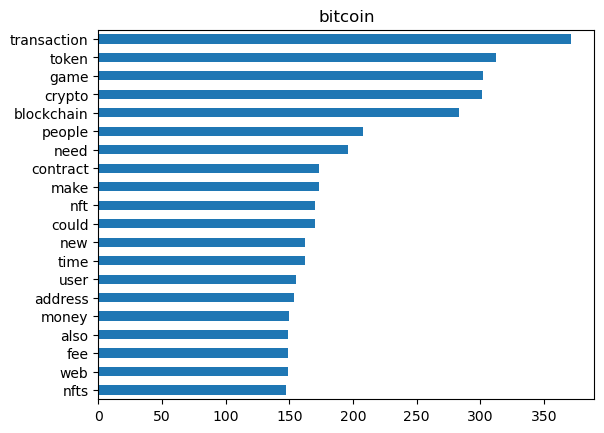

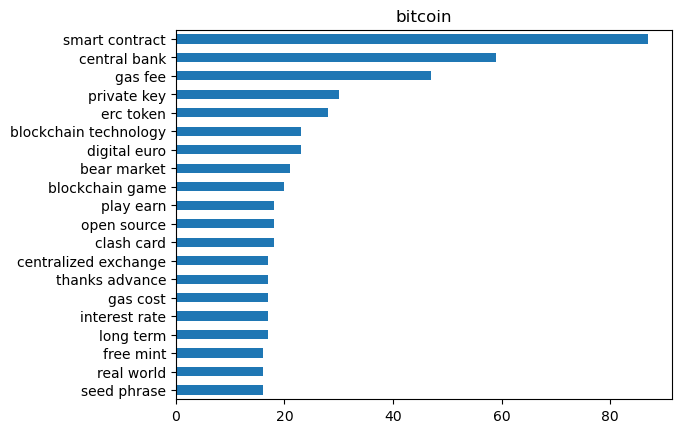

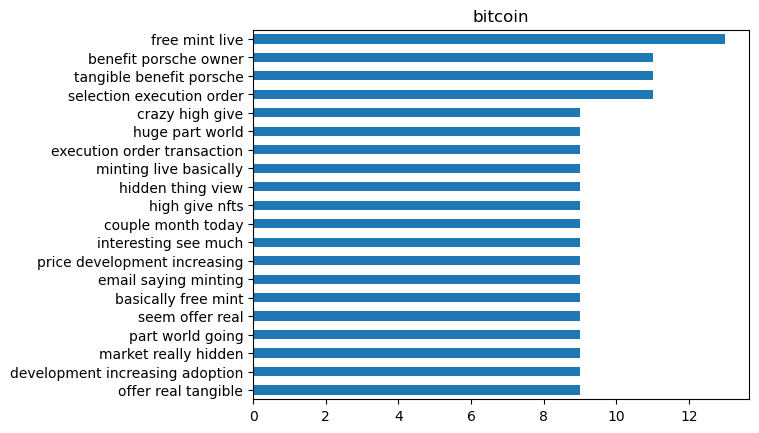

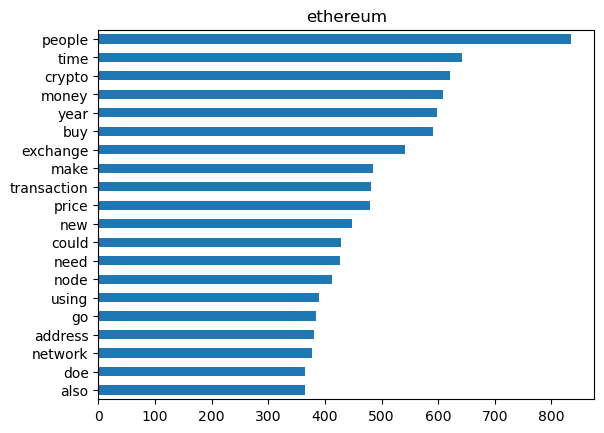

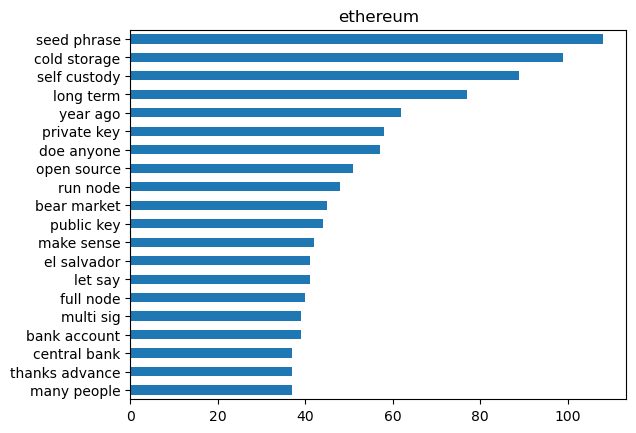

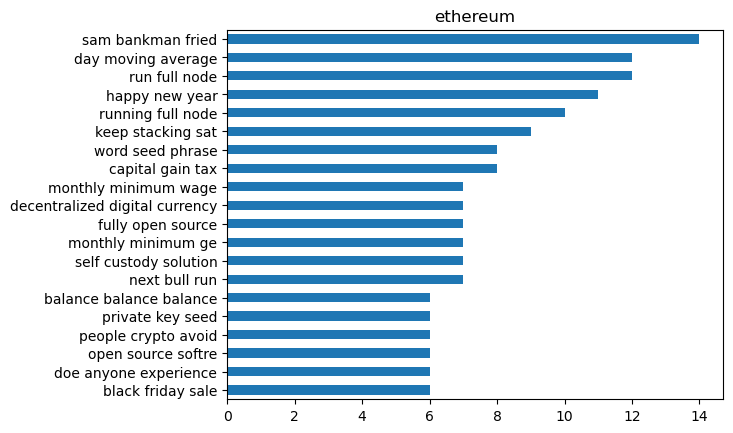

In [996]:
dfs = [btc_selftext, eth_selftext]
startrange = [1,2,3]
#transformers = [cvec, tvec]

counter = 1
for i in dfs:
    for k in startrange:
        plt.figure()
        if counter > 3:
            plt.title('ethereum')
        else:
            plt.title('bitcoin')
 
        ngram_maker(i, cvec, stop, 20, k, k)
        counter+=1
    else:
        pass




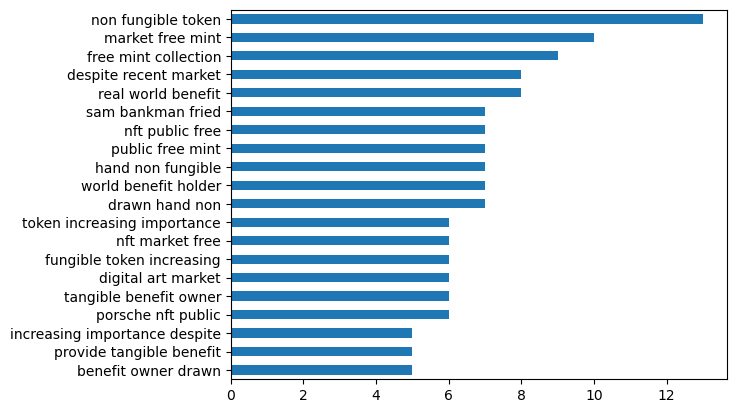

In [997]:
cvec = CountVectorizer(stop_words = stop, ngram_range = (3,3))
btc_text = cvec.fit_transform(btc_notext['text'])
btc_selftext_corp = pd.DataFrame(btc_text.todense(), columns = cvec.get_feature_names_out())
btc_selftext_corp.sum().T.sort_values(ascending = True).tail(20).plot.barh();

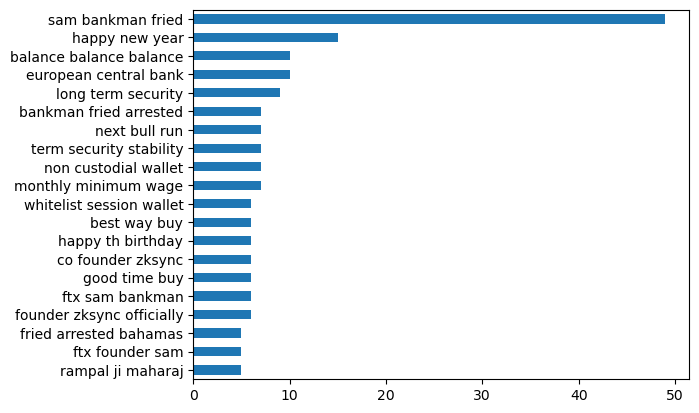

In [998]:
cvec = CountVectorizer(stop_words = stop,  ngram_range = (3,3))
eth_text = cvec.fit_transform(eth_notext['text'])
eth_selftext_corp = pd.DataFrame(eth_text.todense(), columns = cvec.get_feature_names_out())
eth_selftext_corp.sum().T.sort_values(ascending = True).tail(20).plot.barh();

# Sentiment analysis

In [999]:
sent.polarity_scores('fungible token increasing')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [1000]:
btc_selftext.shape

(748, 2)

In [1001]:
btc_selftext.reset_index
eth_selftext.reset_index
print(eth_selftext.index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936],
           dtype='int64', length=2846)


In [1002]:
sent = SentimentIntensityAnalyzer()

In [1003]:
def polarity_score(series, df):
    print(df.index)
    array = [] # array of dicts actually
    for row in series:
            #print(row)
        array.append(sent.polarity_scores(row))
    print(df.shape)
    my_map = {"neg": "neg", "neu": "neu", "pos": "pos", 'compound':'compound'}
    newdf = pd.DataFrame.from_records(array)

    #align indexes
    newdf.index = pd.RangeIndex(len(newdf.index))
    df.index = pd.RangeIndex(len(df.index))

    
    finaldf = df.join(newdf)

    return finaldf
    #newdf = df.join(newdf)
    

            
btc_selftext = polarity_score(btc_selftext['text'],btc_selftext)
eth_selftext = polarity_score(eth_selftext['text'],eth_selftext)

Int64Index([2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946,
            ...
            3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694],
           dtype='int64', length=748)
(748, 2)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936],
           dtype='int64', length=2846)
(2846, 2)


In [1004]:
eth_selftext

,subreddit,text,neg,neu,pos,compound
0,0,cost of moving bitcoin off an exchange i decid...,0.087,0.858,0.055,-0.5927
1,0,the new financial system is closer to fruition...,0.080,0.748,0.172,0.9529
2,0,xpub zpub ypub difference and multisig i am se...,0.000,0.987,0.013,0.1901
3,0,btc were traded in venezuela last week using o...,0.080,0.848,0.072,-0.0258
4,0,do you think lightning network ha struggled wi...,0.065,0.877,0.058,0.0928
...,...,...,...,...,...,...
2841,0,centrofi the one stop venue to earn decentrali...,0.033,0.891,0.076,0.9325
2842,0,a quick query so i took a few million sat on t...,0.040,0.775,0.185,0.9568
2843,0,combined global banking market capitalization ...,0.060,0.786,0.155,0.9728
2844,0,invest your coin and earn x of your investment...,0.000,1.000,0.000,0.0000


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

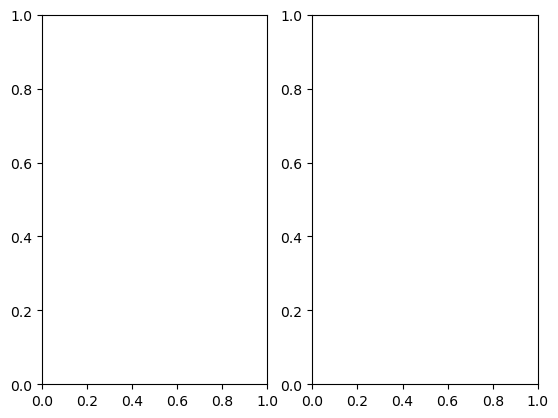

In [1005]:

variables=['neg', 'neu','pos','compound']

fig, axes = plt.subplots(1, 2)

for i, cols in enumerate(variables):
    # scatterplot
    sns.violinplot(x=btc_selftext[cols], y=btc_selftext['subreddit'], ax=axes[0,0])
    # histogram
    sns.violinplot(x=btc_selftext[cols], y=btc_selftext['subreddit'], ax=axes[0,1])


plt.show()

In [ ]:
sns.violinplot(data=btc_selftext[['neg', 'neu','pos','compound']]);

In [ ]:
# This thankfully looks like the original violin data

sns.violinplot(data=eth_selftext[['neg', 'neu','pos','compound']]);


# add title
plt.title("trait distributions for groups, in aggregate")

# show the graph
plt.show();

In [ ]:
for i in variables:
    print(f'bitcoin metrics \n {i} mean: {btc_selftext[i].mean()}, \n {i}  median: {btc_selftext[i].std()}')
    print(f'eth metrics \n {i} mean: {eth_selftext[i].mean()}, \n {i}  median: {eth_selftext[i].std()}')

In [ ]:
btc_selftext.head()

In [ ]:
btc_selftext['text'].str.split()

In [ ]:
arr = []

for row in btc_selftext.text:
    if row.split('.')[1] == 'zpub':
        print(row.index)
        print(row.split()[1])
        arr.append(row)
    else:
        pass
    
print(arr)


In [ ]:
btc_selftext.loc[btc_selftext['text'].str.split()[0] == 'cost']

In [ ]:
def gen_wordcounts(df):
    #cvec = CountVectorizer(stop_words = 'english')
    #tvec = TfidfVectorizer(stop_words = 'english')
    cvec2 = CountVectorizer(stop_words = 'english',ngram_range = (2,2))
    tvec2 = TfidfVectorizer(stop_words = 'english',ngram_range = (2,2))


    for i in [cvec2, tvec2]:
        text = i.fit_transform(df['text'])
        text_corp = pd.DataFrame(text.todense(), columns = i.get_feature_names_out())

        return text_corp.sum().T.sort_values(ascending = True).tail(20).plot.barh();
        


In [ ]:
cvecplot, tvecplot, cvec2plot, tvec2plot = gen_wordcounts(btc)

In [ ]:
text_corp.subreddit.value_counts()

# BTC EDA

In [ ]:
def wordcount(df):
    for i in ['text','titletext']:
        status = cvec.fit_transform(df[i])
        corpus = pd.DataFrame(status.todense(), columns = cvec.get_feature_names_out())
        return corpus
        
df_title_vec, df_titletext_vec = wordcount(df)


# Export

In [ ]:
df_selftext.to_csv('../data/cleaned_selftext.csv', index = False)
df_notext.to_csv('../data/cleaned_notext.csv', index = False)
